In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM
from sklearn.model_selection import train_test_split
import seaborn as sns
url= 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
df = pd.read_csv(url,usecols=['Passengers'])
df.head()
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df)

def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data)-time_step-1):
        a = data[i:(i+time_step),0]
        X.append(a)
        Y.append(data[i+time_step,0])
    return np.array(X), np.array(Y)

time_step=10
X, Y = create_dataset(scaled_data, time_step)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1],1)

model = Sequential()
model.add(SimpleRNN(50, return_sequences=True, input_shape=(time_step,1)))
model.add(SimpleRNN(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, Y_train, epochs=100, batch_size=32, validation_data=(X_test, Y_test), verbose=1)
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
Y_train = scaler.inverse_transform([Y_train])
Y_test = scaler.inverse_transform([Y_test])

train_rmse = np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0]))
test_rmse = np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0]))

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')
from statsmodels.tsa.arima.model import ARIMA

model_arima = ARIMA(df, order=(5,1,0))
model_arima_fit = model_arima.fit()

arima_pred = model_arima_fit.forecast(steps=len(X_test))

arima_rmse = np.sqrt(mean_squared_error(df[-len(arima_pred):], arima_pred))
print(f' ARIMA RMSE: {arima_rmse}')

plt.figure(figsize=(12,6))
plt.plot(df, label='Actual', color='blue')
plt.plot(range(time_step, time_step+len(train_predict)), train_predict, color='green', label='Train Predictions')
plt.plot(range(len(df)-len(test_predict), len(df)), test_predict, color='red', label='Test Predictions')

plt.legend()
plt.title('RNN Predictions vs. Actual')
plt.xlabel('Time')
plt.ylabel('Passengers')
plt.show()
plt.figure(figsize=(12,6))
plt.plot(df, label='Actual')
plt.plot(range(len(df)-len(arima_pred), len(df)), arima_pred, color='green', label='ARIMA Prediction')
plt.legend()
plt.title('ARIMA Predictions vs. Actual')
plt.xlabel('Time')
plt.ylabel('Passengers')
plt.show()







import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
stock_symbol = 'AAPL'
df = yf.download(stock_symbol, start='2010-01-01', end='2023-01-01')

data = df[['Close']].values
scaler = MinMaxScaler(feature_range=(0,1))
data_scaled = scaler.fit_transform(data)

train_size = int(len(data_scaled)*0.8)
train, test = data_scaled[0:train_size], data_scaled[train_size:]

def create_dataset(dataset, look_back=60):
    X, Y = [], []
for i in range(len(dataset)-look_back):
        X.append(dataset[i:i+look_back, 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 60
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

model_lstm = Sequential()
model_lstm.add(LSTM(50, input_shape=(look_back, 1)))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error', optimizer='adam')

model_gru = Sequential()
model_gru.add(GRU(50, input_shape=(look_back, 1)))
model_gru.add(Dense(1))
model_gru.compile(loss='mean_squared_error', optimizer='adam')

model_lstm.fit(X_train, Y_train, epochs=20, batch_size=32, verbose=1)
model_gru.fit(X_train, Y_train, epochs=20, batch_size=32, verbose=1)

lstm_predictions = model_lstm.predict(X_test)
gru_predictions = model_gru.predict(X_test)

lstm_predictions = scaler.inverse_transform(lstm_predictions)
gru_predictions = scaler.inverse_transform(gru_predictions)
Y_test_actual = scaler.inverse_transform([Y_test])

future_steps = 30
last_sequence = X_test[-1]

lstm_future_predictions = []
for _ in range(future_steps):
    prediction = model_lstm.predict(np.reshape(last_sequence, (1, look_back, 1)))
    lstm_future_predictions.append(prediction[0][0])
    last_sequence = np.append(last_sequence[1:], prediction[0])

last_sequence = X_test[-1]
gru_future_predictions = []
for _ in range(future_steps):
    prediction = model_gru.predict(np.reshape(last_sequence, (1, look_back, 1)))
    gru_future_predictions.append(prediction[0][0])
    last_sequence = np.append(last_sequence[1:], prediction[0])

lstm_future_predictions = scaler.inverse_transform(np.array(lstm_future_predictions).reshape(-1, 1))
gru_future_predictions = scaler.inverse_transform(np.array(gru_future_predictions).reshape(-1, 1))

future_range = np.arange(len(Y_test_actual[0]), len(Y_test_actual[0])+ future_steps)

plt.figure(figsize=(14,7))
plt.plot(Y_test_actual[0], label='Actual Stock Price', color='blue')
plt.plot(lstm_predictions, label='LSTM Predictions', color='orange')
plt.plot(gru_predictions, label='GRU Predictions', color='green')

plt.plot(future_range, lstm_future_predictions, label='LSTM Future Predictions', color='red')
plt.plot(future_range, gru_future_predictions, label='GRU Future Predictions', color='purple')

plt.title(f'{stock_symbol} Stock Price Prediction and Future Forecasting - LSTM vs GRU')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.legend()
plt.show()



SyntaxError: invalid non-printable character U+00A0 (1741773085.py, line 18)

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM
from sklearn.model_selection import train_test_split
import seaborn as sns
url= 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
df = pd.read_csv(url,usecols=['Passengers'])
df.head()
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df)

def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data)-time_step-1):
        a = data[i:(i+time_step),0]
        X.append(a)
        Y.append(data[i+time_step,0])
        return np.array(X), np.array(Y)

time_step=10
X, Y = create_dataset(scaled_data, time_step)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1],1)

model = Sequential()
model.add(SimpleRNN(50, return_sequences=True, input_shape=(time_step,1)))
model.add(SimpleRNN(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, Y_train, epochs=100, batch_size=32, validation_data=(X_test, Y_test), verbose=1)
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
Y_train = scaler.inverse_transform([Y_train])
Y_test = scaler.inverse_transform([Y_test])

train_rmse = np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0]))
test_rmse = np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0]))

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')
from statsmodels.tsa.arima.model import ARIMA

model_arima = ARIMA(df, order=(5,1,0))
model_arima_fit = model_arima.fit()

arima_pred = model_arima_fit.forecast(steps=len(X_test))

arima_rmse = np.sqrt(mean_squared_error(df[-len(arima_pred):], arima_pred))
print(f' ARIMA RMSE: {arima_rmse}')

plt.figure(figsize=(12,6))
plt.plot(df, label='Actual', color='blue')
plt.plot(range(time_step, time_step+len(train_predict)), train_predict, color='green', label='Train Predictions')
plt.plot(range(len(df)-len(test_predict), len(df)), test_predict, color='red', label='Test Predictions')

plt.legend()
plt.title('RNN Predictions vs. Actual')
plt.xlabel('Time')
plt.ylabel('Passengers')
plt.show()
plt.figure(figsize=(12,6))
plt.plot(df, label='Actual')
plt.plot(range(len(df)-len(arima_pred), len(df)), arima_pred, color='green', label='ARIMA Prediction')
plt.legend()
plt.title('ARIMA Predictions vs. Actual')
plt.xlabel('Time')
plt.ylabel('Passengers')
plt.show()


ValueError: With n_samples=1, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
D:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 4.9870e-05
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 4.1966e-06
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 3.4517e-05
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 1.9610e-05
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 1.4623e-06
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 3.6597e-06
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 1.3855e-05
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 1.4967e-05
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 7.5207e-06
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 8.8102e-07
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 8.6979e-07
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 5.3446e-06
Epoch 13/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 8.0880e-06
Epoch 14/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 6.2489e-06
Epoch 15/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms

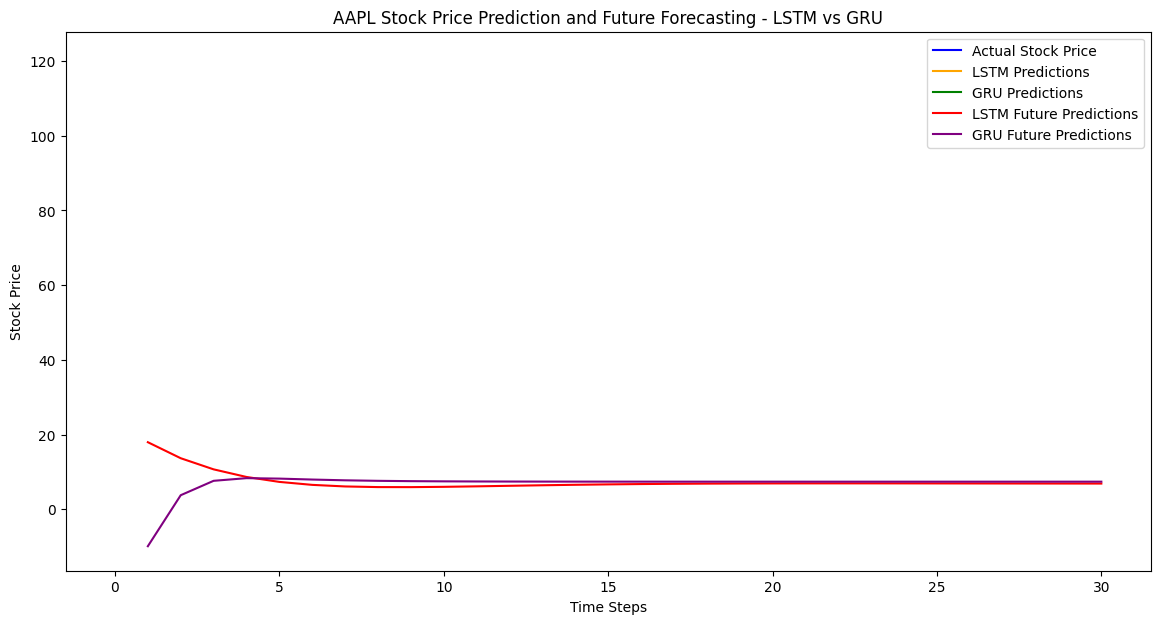

Gayatri Kulkarni -53004230002


In [15]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
stock_symbol = 'AAPL'
df = yf.download(stock_symbol, start='2010-01-01', end='2023-01-01')

data = df[['Close']].values
scaler = MinMaxScaler(feature_range=(0,1))
data_scaled = scaler.fit_transform(data)

train_size = int(len(data_scaled)*0.8)
train, test = data_scaled[0:train_size], data_scaled[train_size:]

def create_dataset(dataset, look_back=60):
    X, Y = [], []
    for i in range(len(dataset)-look_back):
        X.append(dataset[i:i+look_back, 0])
        Y.append(dataset[i + look_back, 0])
        return np.array(X), np.array(Y)

look_back = 60
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

model_lstm = Sequential()
model_lstm.add(LSTM(50, input_shape=(look_back, 1)))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error', optimizer='adam')

model_gru = Sequential()
model_gru.add(GRU(50, input_shape=(look_back, 1)))
model_gru.add(Dense(1))
model_gru.compile(loss='mean_squared_error', optimizer='adam')

model_lstm.fit(X_train, Y_train, epochs=20, batch_size=32, verbose=1)
model_gru.fit(X_train, Y_train, epochs=20, batch_size=32, verbose=1)

lstm_predictions = model_lstm.predict(X_test)
gru_predictions = model_gru.predict(X_test)

lstm_predictions = scaler.inverse_transform(lstm_predictions)
gru_predictions = scaler.inverse_transform(gru_predictions)
Y_test_actual = scaler.inverse_transform([Y_test])

future_steps = 30
last_sequence = X_test[-1]

lstm_future_predictions = []
for _ in range(future_steps):
    prediction = model_lstm.predict(np.reshape(last_sequence, (1, look_back, 1)))
    lstm_future_predictions.append(prediction[0][0])
    last_sequence = np.append(last_sequence[1:], prediction[0])

last_sequence = X_test[-1]
gru_future_predictions = []
for _ in range(future_steps):
    prediction = model_gru.predict(np.reshape(last_sequence, (1, look_back, 1)))
    gru_future_predictions.append(prediction[0][0])
    last_sequence = np.append(last_sequence[1:], prediction[0])

lstm_future_predictions = scaler.inverse_transform(np.array(lstm_future_predictions).reshape(-1, 1))
gru_future_predictions = scaler.inverse_transform(np.array(gru_future_predictions).reshape(-1, 1))

future_range = np.arange(len(Y_test_actual[0]), len(Y_test_actual[0])+ future_steps)

plt.figure(figsize=(14,7))
plt.plot(Y_test_actual[0], label='Actual Stock Price', color='blue')
plt.plot(lstm_predictions, label='LSTM Predictions', color='orange')
plt.plot(gru_predictions, label='GRU Predictions', color='green')

plt.plot(future_range, lstm_future_predictions, label='LSTM Future Predictions', color='red')
plt.plot(future_range, gru_future_predictions, label='GRU Future Predictions', color='purple')

plt.title(f'{stock_symbol} Stock Price Prediction and Future Forecasting - LSTM vs GRU')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
print("Gayatri Kulkarni -53004230002")
